In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib

import MeCab
import ipadic
from urllib.request import urlopen

import itertools
import collections

import wordcloud
from wordcloud import WordCloud

import networkx as nx

In [2]:
df_answers = pd.read_csv('answers.csv', index_col=0)
contents = df_answers['content']

# 形態素解析

In [3]:
# Mecabで形態素解析
tagger = MeCab.Tagger() # MeCab.Tagger(ipadic.MECAB_ARGS)

# ストップワードを取得
slothlib_path = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
slothlib_file = urlopen(slothlib_path)
stopwords = [line.decode("utf-8").strip() for line in slothlib_file]
stopwords = [ss for ss in stopwords if not ss==u'']
stopwords += ["する","ある","できる","ない","れる","なる","いる","思う","感じる"]

In [4]:
# 形態素解析をして単語のリストを取得する関数
def get_word_list(content):
    # ' , 全角スペース(\u3000)を除く
    content = content.replace('\'', '').replace(',', '').replace('\\u3000', '')
    # 改行で分割
    words = MeCab.Tagger(ipadic.MECAB_ARGS).parse(content).split('\n')
    # EOS, 空白は除く
    words = [word for word in words if word not in ['EOS', '']]
    # 必要な単語を抽出して格納するリスト
    word_list = []

    # 格納していく
    for word in words:
        word_info = word.split(',')

        word_raw, word_type = word_info[0].split('\t')
        word_type2 = word_info[1]

        word_base = word_info[-3]

        if word_type not in ['記号', '助詞', '助動詞', '接頭詞'] and word_type2 != '非自立' and word_base not in stopwords:
            word_list.append(word_base)
            
        # word_baseが * になっていることがある（カタカナ語など）
        # そのときは word_raw を追加
        if word_base == '*' and word_type =='名詞':
            word_list.append(word_raw)
            
    return word_list

word_list_list = []
for content in contents:
    word_list_list.append(get_word_list(content))

In [5]:
# 単語の一覧
all_words = list(itertools.chain.from_iterable(word_list_list))

In [6]:
# 登場回数
num = 5

# 要素をカウントする
counter = collections.Counter(all_words)
# 登場回数で絞る
counter = dict([(k,v) for (k,v) in counter.items() if v>num])
# 登場回数でソート
counter = dict(sorted(counter.items(), key=lambda x:x[1], reverse=True))

# ワードクラウド

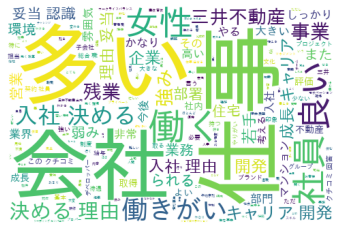

In [7]:
wordcloud = WordCloud()
# ワードクラウドの作成, 
wc = WordCloud(width=480, height=320, background_color='white', font_path='ipaexg.ttf')
wc.generate('\n'.join(all_words))
plt.imshow(wc)
plt.axis('off')
plt.show()

# ジャッカード係数

In [8]:
# ジャッカード係数
def jaccard_similarity(x, y):
    # 単語x, y が含まれる文書の積集合の数
    intersection = len([wl for wl in word_list_list if (x in wl) & (y in wl)])
    # 単語x, y が含まれる文書の和集合の数
    union = len([wl for wl in word_list_list if (x in wl) | (y in wl)])
    
    return intersection / union

In [9]:
from tqdm import tqdm

list_js = []
for x, y in tqdm(list(itertools.combinations(counter.keys(), 2))):
    list_js.append([x, y, jaccard_similarity(x, y)])

100%|███████████████████████████████████████████████████████████████████████████| 43660/43660 [01:26<00:00, 504.97it/s]


In [10]:
df_js = pd.DataFrame(list_js, columns=['x', 'y', 'js'])
df_js = df_js.sort_values('js', ascending=False)
df_js = df_js.head(200)

# 共起ネットワーク

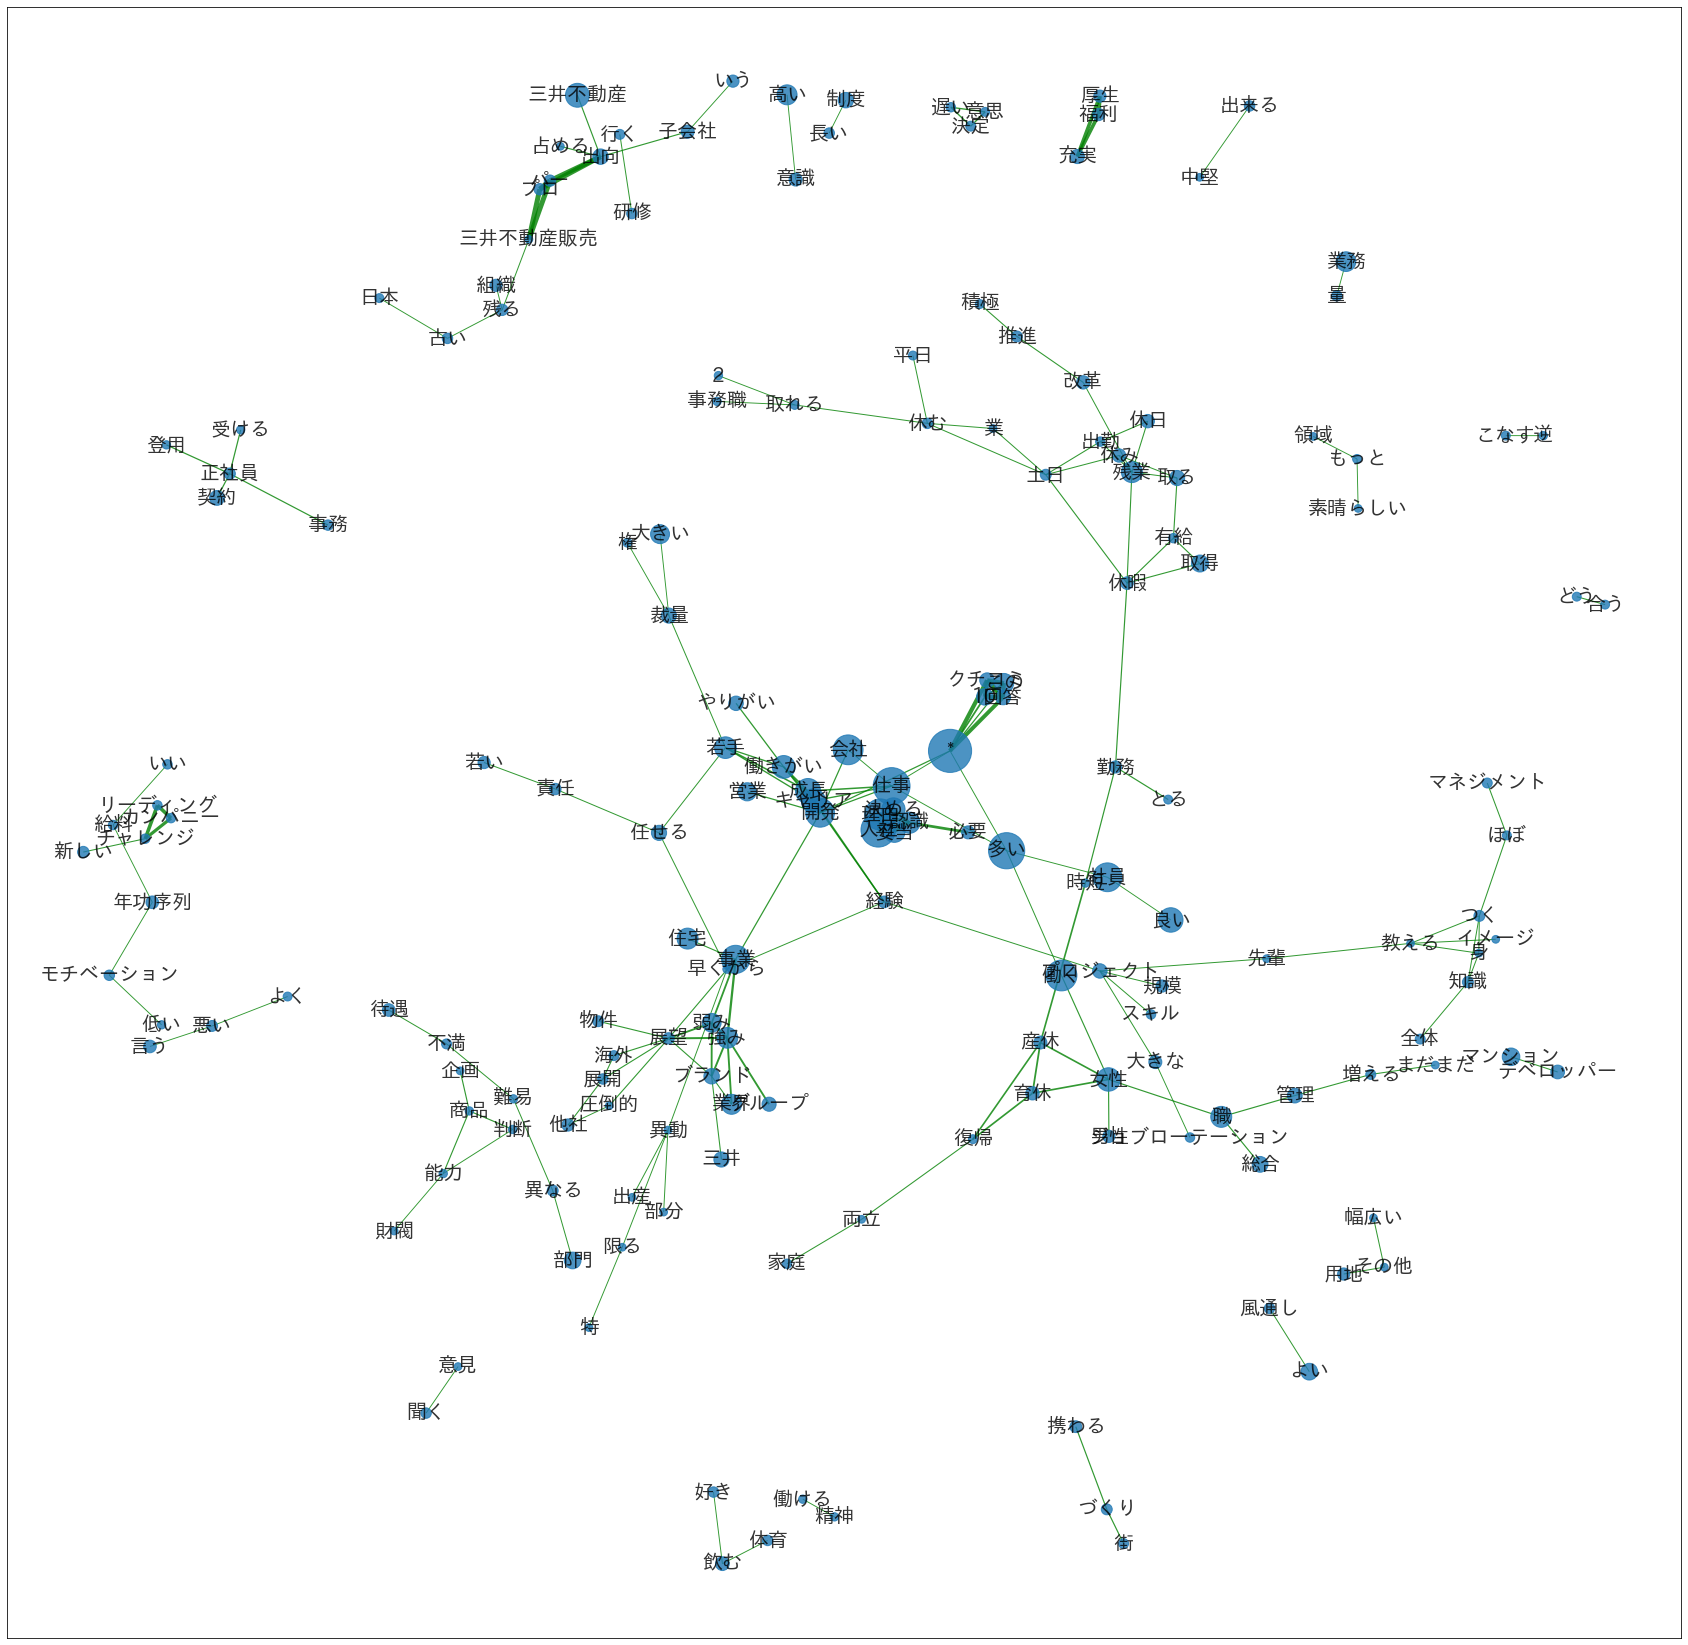

In [11]:
plt.figure(figsize=(30, 30))

G = nx.Graph()

G.add_weighted_edges_from(df_js.values)

node_size = list(map(lambda x: counter[x]*10, (G.nodes)))
edge_width = df_js['js']*5
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx(G, #pos,
                 node_size=node_size, width=edge_width,
                 alpha=0.8, edge_color="g",
                 font_family='IPAexGothic', font_size=20)
plt.show()